In [50]:
# this notebook is meant to save out figs from lateral sed flux
# because it takes about ten minutes to run

In [51]:
# LIBRARIES
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# MODEL PARAMETERS

# gridding stuff (m)
dx = 1
x = np.arange(0, 10, dx)

# runoff rate (m/yr)
r = np.zeros(len(x))
r[:] = 10.

# topographic information
# characteristic sed thickness
Hstar = 0.5
# sediment layer
H = Hstar + np.zeros(len(x))
# bedrock elev
etab = -H
# total elev
eta = etab + H

# abrasion coefficients (from Attal and Lave 2006 in % per km)
# igneous bedrock
beta_ig = np.zeros(len(x))
beta_ig[:3] = 0.00004
# sedimentary bedrock
beta_sed = np.zeros(len(x))
beta_sed[3:] = 0.00014
# igneous gravel clasts
# atr_factor = 0.00004
atr_factor = 0.004

# erodibility values (1/m)
# igneous bedrock
k_ig = np.zeros(len(x))
k_ig[:3] = 0.0001
# sedimentary bedrock
k_sed = np.zeros(len(x))
k_sed[3:] = 0.001

# fraction of lateral sed that's coarse
gamma = np.zeros(len(x))
gamma[:] = 0.5
gamma_nolat = np.zeros(len(x))
gamma_nolat[:] = 0.0

In [53]:
# MAIN MODEL FUNCTION

# this model represents two bedrock lithologies in the domain, 
# but only one contributing sediment to bedload

def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     atr_factor,
                     k_ig,
                     k_sed,
                     r,
                     gamma,
                     baselevel_rate = 0.001,
                     num_steps = 5000000, 
                     c = 1,
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    q = r * x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    ql = np.zeros(len(x)) # lateral sediment flux
    dt_global = (0.2 * dx * dx / (c*q[-1]))  # "global" time-step size
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        

        # CALCULATE RATES
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[1:])   # <== change indexing: qs[1] represents node 0
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        #  calc grain attrition rate
        atr = atr_factor * qs[1:]
        
        # calc lateral sediment influx
        ql[0] = 0
        ql[1:] = ((bedrock_ero[:-1] * gamma[1:]) / atr_factor) * (1 - np.exp(-atr_factor * ((1./3.)*x[1:])))
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig - ql[1:]))
        
        
        
        # CALCULATE MAX ALLOWABLE TIME-STEP SIZE
        
        #  track total erosion rate
        total_ero[:-1] = bedrock_ero[:-1] - sedimentation_rate[:-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
        if any(total_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print(cum_time)
        
    return (S, qs, eta, etab, bedrock_ero, atr, ql, sedimentation_rate, H, total_ero)

In [54]:
# create model run just to test, 
#make sure running properly before adding lateral sed flux

# create an input experiment
TL_ss = [x, dx, Hstar, H, etab, eta, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, gamma]

# and run away with it!
(slope,
 sed_flux,
 topography,
 bedrock_elevation,
 bedrock_erosion_rate,
 attrition_rate,
 lateral_sed,
 sedimentation_rate,
 sediment_thickness,
 total_erosion_rate) = two_lith_one_sed(*TL_ss)

11111.113332718829


In [55]:
# check for steady state condition
print(total_erosion_rate)

[0.00099994 0.001      0.001      0.001      0.001      0.001
 0.001      0.001      0.001      0.001     ]


In [56]:
# now check out widths
kb = 8.3e-8 # 2.61 # wickert and schildgen width coefficient
D = 0.2
kh = 0.3
Q = r * kh * x**2

width = (kb * Q[1:] * slope**(7./6.)) / (D**(3./2.))

Text(0.5, 1.0, 'downstream profile slopes')

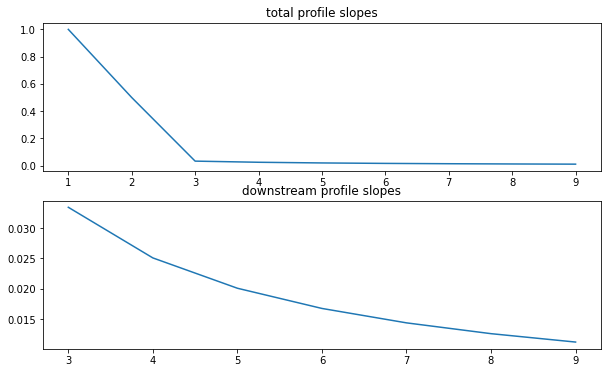

In [75]:
# now make some plots
fig, axs = plt.subplots(2, figsize = (10, 6))

axs[0].plot(x[1:], slope)
axs[0].set_title('total profile slopes')
# axs[1]. plot(x[1:3], slope[:2])
axs[1].plot(x[3:], slope[2:])
axs[1].set_title('downstream profile slopes')

Text(0.5, 1.0, 'topography with lateral sediment')

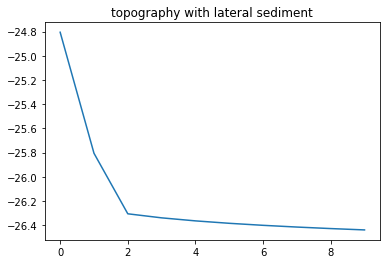

In [76]:
plt.plot(x, topography)
plt.title('topography with lateral sediment')

Text(0.5, 1.0, 'lateral sediment inputs')

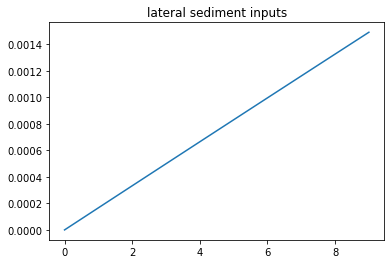

In [77]:
plt.plot(x, lateral_sed)
plt.title('lateral sediment inputs')

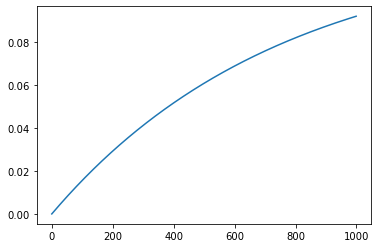

In [85]:
# investigating linear appearance of lateral sed flux

x_2 = np.arange(0, 1000, 1)
q_lat_2 = ((0.001 * 0.5)/ atr_factor) * (1 - np.exp(-atr_factor * (1./3.) * x_2))

plt.plot(x_2, q_lat_2)

Text(0.5, 1.0, 'sediment thickness')

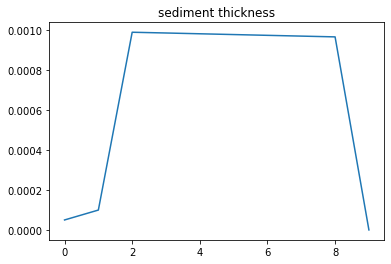

In [78]:
plt.plot(x, sediment_thickness)
plt.title('sediment thickness')

Text(0.5, 1.0, 'sedimentation rate')

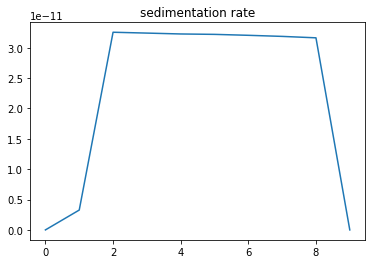

In [79]:
plt.plot(x, sedimentation_rate)
plt.title('sedimentation rate')

In [62]:
print(sedimentation_rate)

[7.70128516e-16 3.27097418e-12 3.25496135e-11 3.24099862e-11
 3.22654474e-11 3.21992464e-11 3.20449605e-11 3.18666041e-11
 3.16310681e-11 0.00000000e+00]


In [68]:
# now see what happens to slopes with no lateral sediment influx
# create an input experiment
TL_ss_nolat = [x, dx, Hstar, H, etab, eta, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, gamma_nolat]

# and run away with it!
(slope_nolat,
 sed_flux_nolat,
 topography_nolat,
 bedrock_elevation_nolat,
 bedrock_erosion_rate_nolat,
 attrition_rate_nolat,
 lateral_sed_nolat,
 sedimentation_rate_nolat,
 sediment_thickness_nolat,
 total_erosion_rate_nolat) = two_lith_one_sed(*TL_ss_nolat)

11111.113332718829


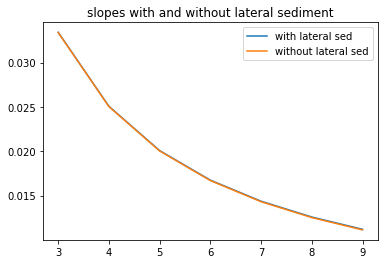

In [83]:
plt.plot(x[3:], slope[2:], label = 'with lateral sed')
plt.plot(x[3:], slope_nolat[2:], label = 'without lateral sed')
plt.title('slopes with and without lateral sediment')
plt.legend()

In [70]:
print(slope)
print(slope_nolat)

[1.00001316 0.50007455 0.03342844 0.02507792 0.02007634 0.01674427
 0.0143662  0.01258438 0.01120005]
[1.00005976 0.50005965 0.0333967  0.02504241 0.0200338  0.01669472
 0.01430966 0.01252087 0.01112959]


Okay, so the difference is tiny, but slopes with lateral sediment are actually slightly higher. So maybe this explains why with is no longer decreasing downstream (see below). We don't see the difference in width relationship in this model, but we also know our grid is so small that we're not seeing the full saturating exponential behavior of the lateral sediment influx. So maybe this effect will be great enough to correct wonky width on full grid?

In [71]:
width_nolat = (kb * Q[1:] * slope_nolat**(7./6.)) / (D**(3./2.))

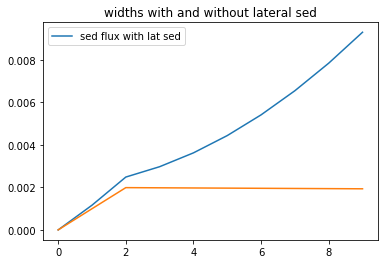

In [88]:
# plt.plot(x[1:], width, label = 'with lateral sed')
# plt.plot(x[1:], width_nolat, label = 'without lateral sed')
plt.plot(x, sed_flux, label = 'sed flux with lat sed')
plt.plot(x, sed_flux_nolat)
plt.title('widths with and without lateral sed')
plt.legend()